## import amd setup

In [1]:
import numpy as np
import pyDR as DR
from pyDR.Project import Project
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import pickle
import os
from copy import deepcopy

In [2]:
#full_ile_resn = [48, 80, 123, 137, 142, 143, 162, 190, 202, 208, 213, 231, 269]
ile_resn = [3, 13, 23, 30, 36, 44, 61]
#test_list = ["test_001", "test_002", "test_003", "test_010", "test_011", "test_014", "test_015", "test_charm"]
test_list = ["test_001", "test_002", "test_015", "test_003", "test_010", "test_014", "test_011", "test_charm"]
trj_slices = [1,2,3,4]
#color_list = ["lightcoral","firebrick","maroon","darkgreen","cornflowerblue","royalblue","gold"]
color_list = ["#ff5100","#b35348","#ff00e8","#7a0091","#0059ff","#008da5","#7cfe89","#fbdc00"]

In [3]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", color_list)

In [4]:
#dir = "/home/mlehner/pyDR/1ubq_data/"
dir = "/localhome/mlehner/nmr/1ubq/"

In [5]:
data = {}
for test in test_list:
    slice_dict = {}
    for trj_slice in trj_slices:
        resn_dict = {}
        for resn in ile_resn:
            try:
                out=pickle.load(open(f"{dir}{test}/{trj_slice}_{resn}.p","rb"))
                resn_dict[resn] = out
            except:
                print(f"Failed to load {dir}{test}/{trj_slice}_{resn}.p")
        slice_dict[trj_slice] = resn_dict
    data[test] = slice_dict

In [6]:
tf=100000
t=np.arange(tf>>1)*.005

In [7]:
def calc_S2_tc(ct, t):
    S2 = ct.mean(0)[tf>>2:tf>>1].mean()
    b=np.min([np.argwhere(ct.mean(0)-S2<0)[0,0], len(ct.mean(0))//2])
    tc0=t[np.argmin(np.abs((ct.mean(0)[:b]-S2)/(1-S2)-np.exp(-1)))]
    tc0_2=2*tc0
    S2_2=S2
    #fun=lambda x:(((x[0]+(1-x[0])*np.exp(-t[:b]/x[1]))-ct.mean(0)[:b])**2).sum()
    #fun=lambda x:(((x[0]+(1-x[0])*np.exp(-t[:b]/x[1]))-ct.mean(0)[:b])**2).sum() + (((x[2]+(1-x[2])*np.exp(-t[:b]/x[3]))-ct.mean(0)[:b])**2).sum()
    # x=[S2,tc0,S2_2,tc0_2]
    # fit funciton: S2 + (1-S2)*((1-S2_2)*exp(-t/tc) + S2_2*exp(-t/tc_2))
    fun = lambda x: (((x[0] + (1-x[0])*((1-x[2])*np.exp(-t[:b]/x[1]) + x[2]*np.exp(-t[:b]/x[3]))) - ct.mean(0)[:b])**2).sum()
    lsq_result = least_squares(fun,[S2,tc0,S2_2,tc0_2])
    S2,tc,S2_2,tc_2 = lsq_result.x
    return S2, tc, S2_2, tc_2

In [8]:
np.vstack([data["test_001"][1][61][0]["ct_finF"][0], data["test_001"][1][61][0]["ct_finF"][1]]).shape

(12, 100001)

In [9]:
def calc_S2_tc_from_multipleCT_with_error(ct, t):
    #ct = np.vstack(ct_list)
    try:
        S2, tc, S2_2, tc_2 = calc_S2_tc(ct, t)
    except Exception as e:
        print(e)
        return np.nan, np.nan, np.nan, np.nan
    return S2, tc, S2_2, tc_2

In [10]:
def calc_S2_tc_from_multipleCT_with_error(ct, t):
    S2_list = []
    tc_list = []
    S2_2_list = []
    tc_2_list = []
    try:
        arrays = np.vsplit(ct, 4)
    except:
        try:
            arrays = np.vsplit(ct, 3)
        except:
            try:
                arrays = np.vsplit(ct, 2)
            except:
                arrays = [ct]
    for ct in arrays:
        try:
            S2,tc,S2_2,tc_2 = calc_S2_tc(ct, t)
            S2_list.append(S2)
            tc_list.append(tc)
            S2_2_list.append(S2_2)
            tc_2_list.append(tc_2)
        except Exception as e:
            print(e)
            return np.nan, np.nan, np.nan, np.nan
    S2 = np.mean(S2_list)
    tc = np.mean(tc_list)
    S2_err = np.std(S2_list)
    tc_err = np.std(tc_list)
    S2_2 = np.mean(S2_2_list)
    tc_2 = np.mean(tc_2_list)
    S2_2_err = np.std(S2_2_list)
    tc_2_err = np.std(tc_2_list)
    return S2, tc, S2_err, tc_err, S2_2, tc_2, S2_2_err, tc_2_err  

In [11]:
print(calc_S2_tc(data["test_001"][1][61][0]["ct_finF"][0], data["test_001"][1][61][0]["t"]))
print(calc_S2_tc(data["test_001"][2][61][0]["ct_finF"][0], data["test_001"][1][61][0]["t"]))
print(calc_S2_tc(data["test_001"][3][61][0]["ct_finF"][0], data["test_001"][1][61][0]["t"]))
print(calc_S2_tc(data["test_001"][4][61][0]["ct_finF"][0], data["test_001"][1][61][0]["t"]))

(0.08480395641353304, 0.026497899100799083, 0.3217032412171307, 0.21545454511256548)
(0.09886540557699201, 0.026293915277502144, 0.3213501786998162, 0.18373195090933628)
(0.09475788233177591, 0.025804520551371196, 0.32221244620476647, 0.1997045558286667)
(0.09561497123260415, 0.027428490628720107, 0.28440976691166076, 0.1914648817152545)


In [12]:
stacked_test001_61 = np.vstack([data["test_001"][i][61][0]["ct_finF"][0] for i in trj_slices])

In [13]:
calc_S2_tc_from_multipleCT_with_error(stacked_test001_61, data["test_001"][1][61][0]["t"])

(0.09351055388872628,
 0.026506206389598132,
 0.005255085080196568,
 0.000589089925355879,
 0.3124189082583435,
 0.19758898339145575,
 0.01617399003550782,
 0.011759846011947107)

In [14]:
#data["test_001"][1]

In [15]:
data_stacked_slices = {}
for test in data:
    resn_dict = {}
    for resn in ile_resn:
        motion_dict = {"ct_finF":{}, "t":{}}
        for motion_selector in [0,1,2,3]:
            stacked_slice_temp = None
            try:
                stacked_slice_temp = np.vstack([data[test][i][resn][0]["ct_finF"][motion_selector] for i in trj_slices])
            except:
                try:
                    stacked_slice_temp = np.vstack([data[test][i][resn][0]["ct_finF"][motion_selector] for i in trj_slices[:-1]])
                except:
                    try:
                        stacked_slice_temp = np.vstack([data[test][i][resn][0]["ct_finF"][motion_selector] for i in trj_slices[1:]])
                    except:
                        print(f"Error in {test} {resn}")
            motion_dict["ct_finF"][motion_selector] = stacked_slice_temp
        motion_dict["t"] = data[test][1][resn][0]["t"]
        resn_dict[resn] = motion_dict
    data_stacked_slices[test] = resn_dict

In [16]:
data_stacked_slices["test_001"][61]["ct_finF"][0].shape

(24, 100001)

In [17]:
data_stacked_slices["test_001"][61]["t"].shape

(100001,)

In [18]:
def create_ct_figure(ct_list, title="", legend_str=[""], showFit=True, xrange=None, yrange=None, save=None, show=True):
    fig = plt.figure()
    ax = fig.add_subplot()
    s2_list = []
    tc_list = []
    S2_err_list = []
    tc_err_list = []
    for ct in ct_list:
        ax.plot(t,ct.mean(0)[:tf>>1])
    for ct in ct_list:
        #S2, tc = calc_S2_tc(ct, t)
        S2, tc, S2_err, tc_err, S2_2, tc_2, S2_2_err, tc_2_err = calc_S2_tc_from_multipleCT_with_error(ct, t)
        if showFit:
            ax.plot(t,S2 + (1-S2)*((1-S2_2)*np.exp(-t/tc) + S2_2*np.exp(-t/tc_2)),color='grey',linestyle=':')
        s2_list.append(S2)
        tc_list.append(tc)
        S2_err_list.append(S2_err)
        tc_err_list.append(tc_err)
    if xrange:
        ax.set_xlim(xrange)
    else:
        ax.set_xlim([0,50*np.max(tc_list)])
    if yrange:
        ax.set_ylim(yrange)
    else:
        ax.set_ylim([0,1.05])
    ax.set_xlabel("time [ns]")
    ax.set_ylabel("S2")
    #ax.legend([f"{leg_str}, S2={s2:.2f}, tc={tc:.2f}" for s2,tc,leg_str in zip(s2_list,tc_list, legend_str)])
    legend_str = [f"{leg_str}, S2={s2:.3f}±{s2_err:.3f}, tc={tc:.3f}±{tc_err:.4f}" for s2,s2_err,tc,tc_err,leg_str in zip(s2_list,S2_err_list,tc_list,tc_err_list, legend_str)]
    ax.legend(legend_str)
    for leg_str in legend_str:
        print(leg_str)
    ax.set_title(title)
    if save:
        plt.savefig(save)
    fig.show()

ILE61, S2=0.096±0.002, tc=0.018±0.0005
ILE13, S2=0.107±0.004, tc=0.014±0.0002


/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


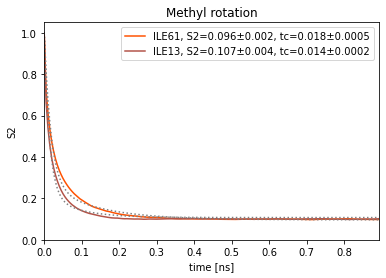

In [19]:
create_ct_figure(ct_list=[data_stacked_slices["test_001"][61]["ct_finF"][0], data_stacked_slices["test_001"][13]["ct_finF"][0]], title="Methyl rotation", legend_str=["ILE61", "ILE13"], showFit=True, xrange=None, yrange=None, save=None, show=True)

ILE61, S2=0.690±0.010, tc=0.024±0.0279
ILE13, S2=0.389±0.040, tc=2.440±1.1638


/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


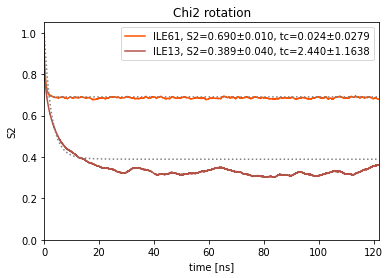

In [20]:
create_ct_figure(ct_list=[data_stacked_slices["test_001"][61]["ct_finF"][1], data_stacked_slices["test_001"][13]["ct_finF"][1]], title="Chi2 rotation", legend_str=["ILE61", "ILE13"], showFit=True, xrange=None, yrange=None, save=None, show=True)

test_001, S2=0.096±0.002, tc=0.018±0.0005
test_002, S2=0.103±0.001, tc=0.005±0.0001
test_015, S2=0.098±0.005, tc=0.017±0.0002
test_003, S2=0.104±0.001, tc=0.005±0.0001
test_010, S2=0.092±0.003, tc=0.017±0.0005
test_014, S2=0.105±0.001, tc=0.006±0.0000
test_011, S2=0.092±0.000, tc=0.017±0.0004
test_charm, S2=0.078±0.006, tc=0.014±0.0001


/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


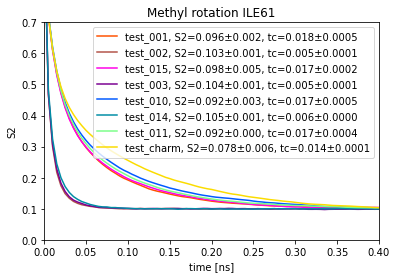

In [21]:
out_data = [data_stacked_slices[test][61]["ct_finF"][0] for test in test_list]
ax = create_ct_figure(out_data, title="Methyl rotation ILE61", legend_str=test_list, showFit=False, xrange=[0,0.4], yrange=[0,0.7], save="../1ubq_data/paris/methylRotationILE61.svg")

/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in square
  # This is added back by InteractiveShellApp.init_path()


test_001, S2=0.690±0.010, tc=0.024±0.0279
test_002, S2=0.724±0.017, tc=0.027±0.0421
test_015, S2=0.731±0.034, tc=0.101±0.1118
test_003, S2=0.689±0.013, tc=0.030±0.0481
test_010, S2=0.618±0.018, tc=0.119±0.0751
test_014, S2=0.599±0.009, tc=0.128±0.0592
test_011, S2=0.682±0.027, tc=0.050±0.0666
test_charm, S2=0.649±0.012, tc=0.008±0.0088


/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


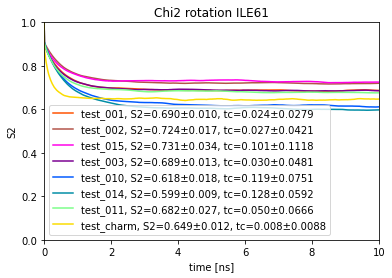

In [22]:
out_data = [data_stacked_slices[test][61]["ct_finF"][1] for test in test_list]
ax = create_ct_figure(out_data, title="Chi2 rotation ILE61", legend_str=test_list, showFit=False, xrange=[0,10], yrange=[0,1], save="../1ubq_data/paris/chi2RotationILE61.svg")

/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in square
  # This is added back by InteractiveShellApp.init_path()


test_001, S2=0.985±0.001, tc=0.005±0.0000
test_002, S2=0.986±0.000, tc=0.005±0.0000
test_015, S2=0.986±0.002, tc=0.005±0.0000
test_003, S2=0.985±0.001, tc=0.005±0.0001
test_010, S2=0.981±0.001, tc=0.005±0.0001
test_014, S2=0.979±0.001, tc=0.005±0.0001
test_011, S2=0.984±0.001, tc=0.005±0.0001
test_charm, S2=0.981±0.001, tc=0.004±0.0007


/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


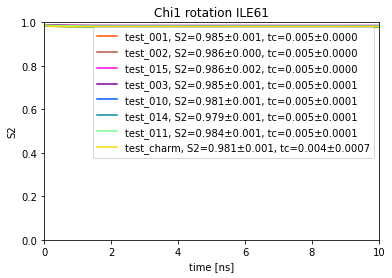

In [23]:
out_data = [data_stacked_slices[test][61]["ct_finF"][2] for test in test_list]
ax = create_ct_figure(out_data, title="Chi1 rotation ILE61", legend_str=test_list, showFit=False, xrange=[0,10], yrange=[0,1], save="../1ubq_data/paris/chi1RotationILE61.svg")

test_001, S2=0.107±0.004, tc=0.014±0.0002
test_002, S2=0.102±0.000, tc=0.004±0.0000
test_015, S2=0.103±0.001, tc=0.014±0.0002
test_003, S2=0.102±0.001, tc=0.004±0.0001
test_010, S2=0.105±0.003, tc=0.014±0.0002
test_014, S2=0.103±0.000, tc=0.004±0.0000
test_011, S2=0.103±0.002, tc=0.014±0.0001
test_charm, S2=0.090±0.003, tc=0.017±0.0004


/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


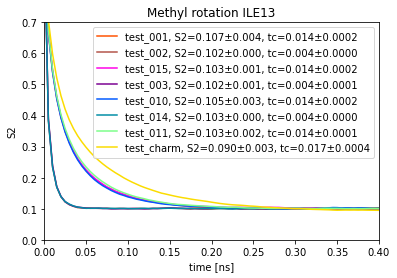

In [24]:
out_data = [data_stacked_slices[test][13]["ct_finF"][0] for test in test_list]
ax = create_ct_figure(out_data, title="Methyl rotation ILE13", legend_str=test_list, showFit=False, xrange=[0,0.4], yrange=[0,0.7], save="../1ubq_data/paris/methylRotationILE13.svg")

test_001, S2=0.389±0.040, tc=2.440±1.1638
test_002, S2=0.451±0.060, tc=3.324±1.5663
test_015, S2=0.339±0.038, tc=4.028±0.3781
test_003, S2=0.379±0.061, tc=1.727±0.3414
test_010, S2=0.343±0.028, tc=2.283±0.7113
test_014, S2=0.389±0.042, tc=3.513±1.4809
test_011, S2=0.477±0.043, tc=1.768±0.2598
test_charm, S2=0.467±0.013, tc=0.066±0.1088


/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


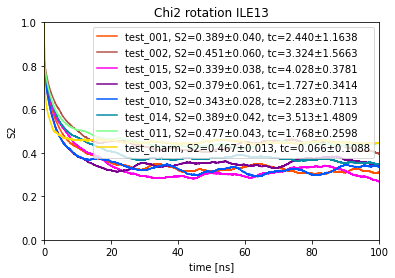

In [25]:
out_data = [data_stacked_slices[test][13]["ct_finF"][1] for test in test_list]
ax = create_ct_figure(out_data, title="Chi2 rotation ILE13", legend_str=test_list, showFit=False, xrange=[0,100], yrange=[0,1], save="../1ubq_data/paris/chi2RotationILE13.svg")

test_001, S2=0.860±0.009, tc=5.042±2.4268
test_002, S2=0.856±0.022, tc=9.645±7.7944
test_015, S2=0.846±0.016, tc=9.510±3.5425
test_003, S2=0.853±0.017, tc=3.583±0.8486
test_010, S2=0.857±0.015, tc=4.220±0.8130
test_014, S2=0.851±0.017, tc=7.830±4.3819
test_011, S2=0.890±0.009, tc=3.418±0.3701
test_charm, S2=0.926±0.009, tc=0.693±0.0752


/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


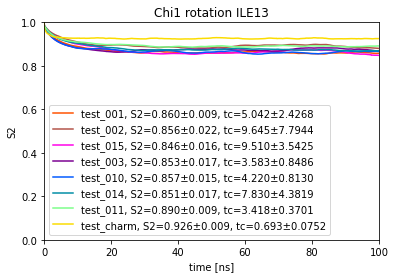

In [26]:
out_data = [data_stacked_slices[test][13]["ct_finF"][2] for test in test_list]
ax = create_ct_figure(out_data, title="Chi1 rotation ILE13", legend_str=test_list, showFit=False, xrange=[0,100], yrange=[0,1], save="../1ubq_data/paris/chi1RotationILE13.svg")

In [27]:
data_stacked_slices["test_001"][61]["ct_finF"][0].shape

(24, 100001)

In [30]:
data_S2_tc = {}
for test in test_list:
    test_dict = {}
    for resn in ile_resn:
        resn_dict = {}
        for motion in [0,1,2,3]:
            S2, tc, S2_err, tc_err, S2_2, tc_2, S2_2_err, tc_2_err = calc_S2_tc_from_multipleCT_with_error(data_stacked_slices[test][resn]["ct_finF"][motion], t)
            resn_dict[motion] = {"S2":S2, "tc":tc, "S2_err":S2_err, "tc_err":tc_err, "S2_2":S2_2, "tc_2":tc_2, "S2_2_err":S2_2_err, "tc_2_err":tc_2_err}
        test_dict[resn] = resn_dict
    data_S2_tc[test] = test_dict

/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in square
  # This is added back by InteractiveShellApp.init_path()
/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
/home/mlehner/.conda/envs/pyDR/lib/python3.7/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Text(0.5, 1.0, 'Methyl rotation ILE61')

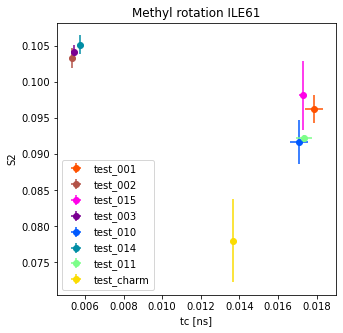

In [31]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for test in test_list:
    ax.errorbar(data_S2_tc[test][61][0]["tc"], data_S2_tc[test][61][0]["S2"], xerr=data_S2_tc[test][61][0]["tc_err"], yerr=data_S2_tc[test][61][0]["S2_err"], fmt='o', label=test)
ax.set_xlabel("tc [ns]")
ax.set_ylabel("S2")
ax.legend()
ax.set_title("Methyl rotation ILE61")

Text(0.5, 1.0, 'Chi2 rotation ILE61')

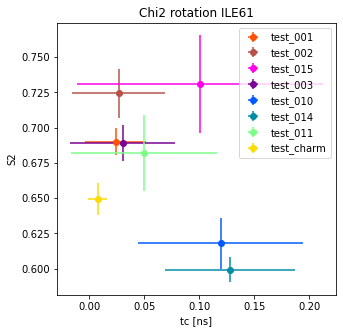

In [32]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for test in test_list:
    ax.errorbar(data_S2_tc[test][61][1]["tc"], data_S2_tc[test][61][1]["S2"], xerr=data_S2_tc[test][61][1]["tc_err"], yerr=data_S2_tc[test][61][1]["S2_err"], fmt='o', label=test)
ax.set_xlabel("tc [ns]")
ax.set_ylabel("S2")
ax.legend()
ax.set_title("Chi2 rotation ILE61")

Text(0.5, 1.0, 'Chi1 rotation ILE61')

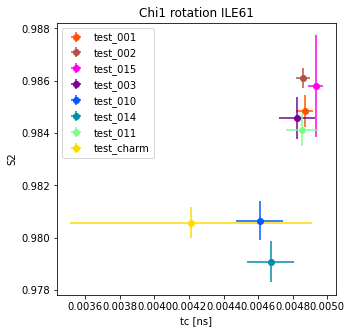

In [33]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for test in test_list:
    ax.errorbar(data_S2_tc[test][61][2]["tc"], data_S2_tc[test][61][2]["S2"], xerr=data_S2_tc[test][61][2]["tc_err"], yerr=data_S2_tc[test][61][2]["S2_err"], fmt='o', label=test)
ax.set_xlabel("tc [ns]")
ax.set_ylabel("S2")
ax.legend()
ax.set_title("Chi1 rotation ILE61")

Text(0.5, 1.0, 'Methyl rotation ILE13')

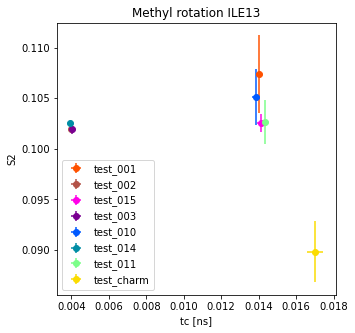

In [34]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for test in test_list:
    ax.errorbar(data_S2_tc[test][13][0]["tc"], data_S2_tc[test][13][0]["S2"], xerr=data_S2_tc[test][13][0]["tc_err"], yerr=data_S2_tc[test][13][0]["S2_err"], fmt='o', label=test)
ax.set_xlabel("tc [ns]")
ax.set_ylabel("S2")
ax.legend()
ax.set_title("Methyl rotation ILE13")

Text(0.5, 1.0, 'Chi2 rotation ILE13')

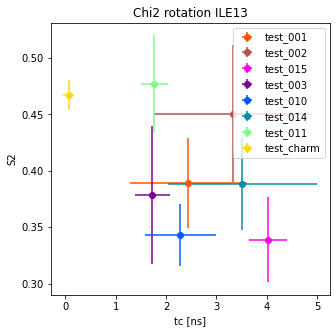

In [36]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for test in test_list:
    ax.errorbar(data_S2_tc[test][13][1]["tc"], data_S2_tc[test][13][1]["S2"], xerr=data_S2_tc[test][13][1]["tc_err"], yerr=data_S2_tc[test][13][1]["S2_err"], fmt='o', label=test)
ax.set_xlabel("tc [ns]")
ax.set_ylabel("S2")
ax.legend()
ax.set_title("Chi2 rotation ILE13")

Text(0.5, 1.0, 'Chi1 rotation ILE13')

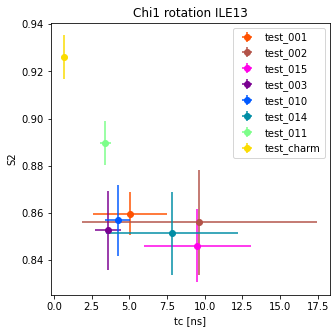

In [37]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for test in test_list:
    ax.errorbar(data_S2_tc[test][13][2]["tc"], data_S2_tc[test][13][2]["S2"], xerr=data_S2_tc[test][13][2]["tc_err"], yerr=data_S2_tc[test][13][2]["S2_err"], fmt='o', label=test)
ax.set_xlabel("tc [ns]")
ax.set_ylabel("S2")
ax.legend()
ax.set_title("Chi1 rotation ILE13")

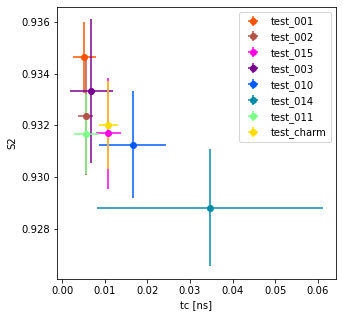

In [38]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for test in test_list:
    ax.errorbar(data_S2_tc[test][61][3]["tc"], data_S2_tc[test][61][3]["S2"], xerr=data_S2_tc[test][61][3]["tc_err"], yerr=data_S2_tc[test][61][3]["S2_err"], fmt='o', label=test)
ax.set_xlabel("tc [ns]")
ax.set_ylabel("S2")
ax.legend()

In [39]:
for motion in [0,1,2,3]:
    print(data_S2_tc[test_list[0]][13][motion]["S2"])

0.10736468742909472
0.3890914401775511
0.8597271928530761
0.8636603531766326


In [40]:
# save data_S2_tc as numpy array
np.save("./1ubq_data/1ubq_data_S2_tc_biexpo.npy", data_S2_tc)

In [41]:
data_S2_tc2 = np.load("./1ubq_data/1ubq_data_S2_tc_biexpo.npy", allow_pickle=True).item()

In [42]:
data_S2_tc2

{'test_001': {3: {0: {'S2': 0.10087638280754298,
    'tc': 0.011351732116536676,
    'S2_err': 0.007603384766025699,
    'tc_err': 0.0015205059265118988,
    'S2_2': 0.30120127024696586,
    'tc_2': 0.16955289337968502,
    'S2_2_err': 0.026841126171086374,
    'tc_2_err': 0.0606898058124325},
   1: {'S2': 0.6665092637182531,
    'tc': 26.422945584187026,
    'S2_err': 0.3350456196478723,
    'tc_err': 45.754999129944196,
    'S2_2': 0.5365881673497206,
    'tc_2': 52.849533755226474,
    'S2_2_err': 0.557713179564816,
    'tc_2_err': 91.53328688511216},
   2: {'S2': 0.9220457701461823,
    'tc': 25.93614807196862,
    'S2_err': 0.12229750575829444,
    'tc_err': 44.914162653474264,
    'S2_2': 0.827500740288614,
    'tc_2': 51.870480652964474,
    'S2_2_err': 0.28591996698923694,
    'tc_2_err': 89.83509508852424},
   3: {'S2': 0.9353757206649833,
    'tc': 16.79452651013783,
    'S2_err': 0.03322557060109248,
    'tc_err': 29.080649302573995,
    'S2_2': 0.8914327822525534,
    'tc_2

NameError: name 'plt' is not defined